In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.animation as animation
import numpy as np
from neurodyn import *

from tqdm import tqdm
from scipy import stats
from pathlib import Path
from math import ceil

import matplotlib_tufte
matplotlib_tufte.setup()
from matplotlib_tufte import *

# rnn p=1

In [4]:
rnn = LowRankRNN.new_valentin(p=1, N=50_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), progress=True)

simulating LowRankRNN{N=50000, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:20<00:00]


In [5]:
def anim(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax = 1500):
	activity = rnn.phi(res.h[:Nmax])
	idx_mapping = np.arange(len(res.h[:Nmax, -1]))

	fig, axes = plt.subplots(ncols=3, figsize=(8, 3), dpi=200,
		width_ratios=[1,30,30], layout=None)

	# neuron index

	axes[1].set_title('Unordered neuron activity', fontsize='medium')
	sc_idx = axes[1].scatter(
		idx_mapping, activity[:, 0], c=activity[:, 0],
		s=3, ec=None, clip_on=False,
		cmap=cmap_bi, vmin=0, vmax=1)
	axes[1].set_xlabel('Neuron index $i$')
	axes[1].set_ylim((0,1))
	axes[1].yaxis.set_visible(False)
	axes[1].spines.left.set_visible(False)
	axes[1].set_xlim((0, Nmax))
	breathe(axes[1], 'x')

	# neuron embedding

	axes[2].set_title('Neural activity in the 1D embedding', fontsize='medium')
	sc_emb = axes[2].scatter(
		rnn.F[:Nmax, 0], activity[:, 0], c=activity[:, 0],
		s=3, ec=None, clip_on=False,
		cmap=cmap_bi, vmin=0, vmax=1)
	axes[2].set_xlabel('Neuron embedding $z_{1i}$')
	# axes[2].set_ylabel('Activity $\\phi(h(z_{1i}))$ [Hz]')
	axes[2].set_ylim((0,1))
	axes[2].yaxis.set_visible(False)
	axes[2].spines.left.set_visible(False)
	axes[2].set_xlim((-3, 3))
	axes[2].set_xticks([-3, 0, 3])
	breathe(axes[2], 'x')

	fig.colorbar(
		sc_emb, cax=axes[0],
		location='left',
		label='Activity $\\phi(h(z_{1i}))$ [Hz]')

	fig.subplots_adjust(wspace=0.2)
	plt.draw()  # force initialization draw
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the scatters
			sc_idx.set_offsets(np.vstack((idx_mapping, activity[:, idt])).T)
			sc_idx.set_array(activity[:, idt])
			sc_emb.set_offsets(np.vstack((rnn.F[:Nmax, 0], activity[:, idt])).T)
			sc_emb.set_array(activity[:, idt])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		# plt.show()
		plt.close()

anim(rnn, res, 'animations/embedding_p=1.mp4', Nmax=1000, time_stride=5)

100%|██████████| 82/82 [00:22<00:00,  3.58it/s]


# rnn p=2

In [53]:
rnn = LowRankRNN.new_valentin(p=2, N=100_000, random_state=42, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), progress=True)

simulating LowRankRNN{N=100000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:22<00:00]


In [54]:
def anim(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax = 1500):
	activity = rnn.phi(res.h[:Nmax])

	fig, axes = plt.subplots(ncols=2, figsize=(4, 3), dpi=200,
		width_ratios=[30, 1], layout=None)

	# neuron embedding

	ss = axes[0].get_subplotspec()
	axes[0].remove()
	axes[0] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[0].set_proj_type('ortho')

	axes[0].set_title('Neural activity in the 2D embedding', fontsize='medium')
	axes[0].scatter(
		rnn.F[:Nmax, 0], rnn.F[:Nmax, 1], np.zeros_like(activity[:, 0]),
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on the floor
	sc_proj1 = axes[0].scatter(
		rnn.F[:Nmax, 0], np.full(Nmax, 4), activity[:Nmax, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	sc_proj2 = axes[0].scatter(
		np.full(Nmax, 4), rnn.F[:Nmax, 1], activity[:Nmax, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2
	sc_emb = axes[0].scatter(
		rnn.F[:Nmax, 0], rnn.F[:Nmax, 1], activity[:Nmax, 0], c=activity[:, 0],
		s=3, alpha=1, ec=None, clip_on=False,
		cmap=cmap_bi, vmin=0, vmax=1
	)  # the full projection
	axes[0].set_xlabel('$z_{1i}$')
	axes[0].set_ylabel('$z_{2i}$')
	axes[0].set_xlim((-4, 4))
	axes[0].set_ylim((-4, 4))
	axes[0].set_zlim((0,1))
	axes[0].view_init(azim=180+45)

	# axes[0].yaxis.set_visible(False)
	# axes[0].spines.left.set_visible(False)
	# breathe(axes[0], 'x')

	fig.colorbar(
		sc_emb, cax=axes[1],
		location='right',
		label='Activity $\\phi(h(z_{1i},z_{2i}))$ [Hz]')

	fig.subplots_adjust(wspace=0.2)
	for _ in range(20):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	# plt.show()
	# return

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the scatters
			sc_emb.set_offsets(np.vstack((rnn.F[:Nmax, 0], rnn.F[:Nmax, 1])).T)
			sc_emb.set_3d_properties(activity[:Nmax, idt].T, 'z')
			sc_emb.set_array(activity[:Nmax, idt])
			# update the shadow z1
			sc_proj1.set_offsets(np.vstack((rnn.F[:Nmax, 0], np.full(Nmax, 4))).T)
			sc_proj1.set_3d_properties(activity[:Nmax, idt].T, 'z')
			# update the shadow z2
			sc_proj2.set_offsets(np.vstack((np.full(Nmax, 4), rnn.F[:Nmax, 1])).T)
			sc_proj2.set_3d_properties(activity[:Nmax, idt].T, 'z')

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		# plt.show()
		plt.close()

anim(rnn, res, 'animations/embedding_p=2.mp4', Nmax=5000, time_stride=5)

100%|██████████| 82/82 [00:34<00:00,  2.40it/s]


# p=2 cycling

In [70]:
nrec = 6
rnn = LowRankCyclingRNN.new_sampled_valentin(
	phi=sigmoid, mapping_samples=ReshapeMapping.new_nrec(nrec=nrec).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=6, shift=1
)
res = rnn.simulate(rnn.F[:, 0], (0, 60), progress=True, cache=True)

simulating LowRankCyclingRNN{N=4096, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=60.000 of 60 [00:04<00:00]


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'Latent trajectory'}, xlabel='Latent $\\kappa_1(t)$', ylabel='Latent $\\kappa_2(t)$'>)

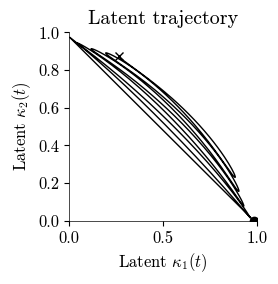

In [71]:
plot_overlap_phase2D(rnn, res)

In [91]:
def anim(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1):
	activity = rnn.phi(res.h)

	fig, axes = plt.subplots(ncols=3, figsize=(8, 3), dpi=200,
		width_ratios=[1, 30, 30], layout='constrained')

	# neuron embedding

	ss = axes[1].get_subplotspec()
	axes[1].remove()
	axes[1] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	axes[1].set_proj_type('ortho')

	shape = (2**nrec, 2**nrec)

	axes[1].set_title('Neural activity in the 2D embedding', fontsize='medium')
	sc_proj1 = axes[1].scatter(
		rnn.F[:, 0], np.full(rnn.N, 3), activity[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on z1
	sc_proj2 = axes[1].scatter(
		np.full(rnn.N, 3), rnn.F[:, 1], activity[:, 0],
		s=3, c='#BBBBBB', alpha=1, ec=None, zorder=0,
	)  # shadow on v2

	surf_emb = axes[1].plot_surface(
		rnn.F[:, 0].reshape(shape), rnn.F[:, 1].reshape(shape), activity[:, 0].reshape(shape),
		cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
	)
	axes[1].set_xlabel('$z_1$')
	axes[1].set_ylabel('$z_2$')
	axes[1].set_xlim((-3, 3))
	axes[1].set_ylim((-3, 3))
	axes[1].set_zlim((0,1))
	axes[1].view_init(azim=180+45)

	fig.colorbar(
		surf_emb, cax=axes[0],
		location='left',
		label='Activity $\\phi(h(z_1,z_2))$ [Hz]')

	kappa = projection(rnn, res.h)
	lat_line = axes[2].plot(*kappa[:, :1], color='black', clip_on=False)[0]
	lat_cur = axes[2].plot(*kappa[:, :1], 'o', color='black', clip_on=False)[0]
	axes[2].set_xlabel('$\\kappa_1$'); axes[2].set_ylabel('$\\kappa_2$');
	axes[2].set_xlim((0, 1)); axes[2].set_ylim((0, 1));
	axes[2].set_title('Latent trajectory', fontsize='medium')
	axes[2].set_aspect('equal')
	breathe(axes[2])

	# fig.subplots_adjust(wspace=0.2)
	for _ in range(20):
		# matplotlib is jank proute
		plt.draw()  # force initialization draw
	
	# plt.show()
	# return

	things = dict(surf_emb=surf_emb)  # need a dict to hold a reference, because we re-assign. thank you, Python nya

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the surface
			things['surf_emb'].remove()
			things['surf_emb'] = axes[1].plot_surface(
				rnn.F[:, 0].reshape(shape), rnn.F[:, 1].reshape(shape), activity[:, idt].reshape(shape),
				cmap=cmap_bi, vmin=0, vmax=1, rasterized=True,
			)

			# update the shadow z1
			sc_proj1.set_offsets(np.vstack((rnn.F[:, 0], np.full(rnn.N, 3))).T)
			sc_proj1.set_3d_properties(activity[:, idt].T, 'z')
			# update the shadow z2
			sc_proj2.set_offsets(np.vstack((np.full(rnn.N, 3), rnn.F[:, 1])).T)
			sc_proj2.set_3d_properties(activity[:, idt].T, 'z')

			# update the latent trajectory
			lat_line.set_data(*kappa[:, :idt+1])
			lat_cur.set_data(*kappa[:, idt:idt+1])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()

anim(rnn, res, 'animations/embedding_p=2_cycling.mp4', time_stride=3)

100%|██████████| 202/202 [01:55<00:00,  1.75it/s]
